In [ ]:
#Прибыльная область ML
#Руководство компании RuCodeCompany решило провести исследование рынка с целью выявления наиболее прибыльной области ML (из тех, в которых компания имеет экспертизу), чтобы сосредоточиться на выполнении новых контрактов именно в этих областях.

#В результате анализа рынка получился датасет ml_profit_all.csv. Каждая строчка датасета содержит результаты оценки одной из областей (например, "Speech synthesis", "Watson", "OCR") за определённый год: выручку от области и расходы на проведение исследований. Поскольку анализ каждой области заказали нескольким агентствам, то для каждой области в каждый год есть несколько различных оценок.

#Ваша задача состоит в том, чтобы выделить наиболее прибыльные области в среднем за все года по оценкам экспертов. А именно, нас интересует 95%-ый доверительный интервал для среднего значения.

#Вам необходимо:

#убрать из датасета строчки с пропущенными значениями;
#добавить столбцы "технология" и "доход"="PROCEEDS"-"EXPENSES";
#для каждой технологии найти среднее значение оценок дохода, выделить три самые прибыльные технологии;
#построить 95%-ый доверительный интервал для трёх самых прибыльных технологий.
#Для построения 95%-ого доверительного интервала используйте метод бутстрепа. Он заключается в следующем. Для каждой технологии:

#Постройте 500 бутстрепных выборок из исходных наблюдений
#Для каждой бутстрепной выборки найдите среднее значение прибыли. Получилась новая выборка из 500 чисел.
#Выберите левую и правую границы интервала так, чтобы 95% элементов новой выборки попали внутрь промежутка (выкинув по 2.5% слева и справа)
#Интересующие нас столбцы:

#PRIMARY_KEY: нужно извлечь название технологии
#EXPENSES : затраты
#PROCEEDS : выручка

In [1]:
import os
import cv2
from glob import glob
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor, Pool, cv
from catboost import CatBoostClassifier
import numpy as np
import random
from scipy.stats import norm

In [2]:
df = pd.read_csv('ml_profit_all.csv')

In [3]:

df.head(10)

,Unnamed: 0,PRIMARY_KEY,EXPENSES,PROCEEDS
0,0,2017_Speech synthesis,304177.0,1659028.0
1,1,2017_Watson,106780.0,720711.0
2,2,2017_OCR,297888.0,1369815.0
3,3,2017_Speech recognition,178571.0,958785.0
4,4,2017_Transformer,2072470.0,16546514.0
5,5,2017_Facial recognition,163253.0,1307986.0
6,6,2017_GPT-2,143542.0,142539.0
7,7,2017_AlphaGo,45945.0,420942.0
8,8,2017_Transformer,64749.0,0.0
9,9,2017_GPT-3,788420.0,5683949.0


In [4]:
df.value_counts()

Unnamed: 0  PRIMARY_KEY            EXPENSES   PROCEEDS 
0           2017_Speech synthesis  304177.0   1659028.0    1
847         2018_OCR               467492.0   2542639.0    1
854         2018_Speech synthesis  1868700.0  9032615.0    1
853         2018_Speech synthesis  515223.0   3202001.0    1
852         2018_Speech synthesis  642088.0   2957101.0    1
                                                          ..
424         2020_Self-driving car  221530.0   2201788.0    1
423         2020_WaveNet           217060.0   1879158.0    1
422         2020_WaveNet           426266.0   4300608.0    1
421         2020_WaveNet           1283052.0  6344130.0    1
1274        2021_MuZero            123012.0   1175899.0    1
Length: 1275, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1715 non-null   int64  
 1   PRIMARY_KEY  1715 non-null   object 
 2   EXPENSES     1275 non-null   float64
 3   PROCEEDS     1275 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 53.7+ KB


In [6]:
df.describe()

,Unnamed: 0,EXPENSES,PROCEEDS
count,1715.000000,1.275000e+03,1.275000e+03
mean,857.000000,7.678200e+05,4.241109e+06
std,495.222172,1.147028e+06,5.631152e+06
min,0.000000,3.102000e+04,0.000000e+00
25%,428.500000,1.899575e+05,1.088766e+06
50%,857.000000,4.035480e+05,2.498847e+06
75%,1285.500000,8.279320e+05,4.901622e+06
max,1714.000000,9.990221e+06,5.090457e+07


In [7]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print (categorical_columns)
print (numerical_columns)

['PRIMARY_KEY']
['Unnamed: 0', 'EXPENSES', 'PROCEEDS']


In [8]:
df[categorical_columns].describe()

,PRIMARY_KEY
count,1715
unique,90
top,2019_Transformer
freq,49


In [9]:
for c in categorical_columns:
    print (df[c].unique())

['2017_Speech synthesis' '2017_Watson' '2017_OCR'
 '2017_Speech recognition' '2017_Transformer' '2017_Facial recognition'
 '2017_GPT-2' '2017_AlphaGo' '2017_GPT-3' '2017_Human image synthesis'
 '2017_WaveNet' '2017_Self-driving car' '2017_BERT' '2017_Word2vec'
 '2017_Q-learning' '2017_MuZero' '2018_Speech synthesis' '2018_Watson'
 '2018_OCR' '2018_Speech recognition' '2018_Transformer'
 '2018_Facial recognition' '2018_GPT-2' '2018_AlphaGo' '2018_GPT-3'
 '2018_Human image synthesis' '2018_WaveNet' '2018_Self-driving car'
 '2018_BERT' '2018_Word2vec' '2018_Q-learning' '2018_MuZero'
 '2019_Speech synthesis' '2019_Watson' '2019_OCR'
 '2019_Speech recognition' '2019_Transformer' '2019_Facial recognition'
 '2019_GPT-2' '2019_AlphaGo' '2019_GPT-3' '2019_Human image synthesis'
 '2019_WaveNet' '2019_Self-driving car' '2019_BERT' '2019_Word2vec'
 '2019_Q-learning' '2019_MuZero' '2020_Speech synthesis' '2020_Watson'
 '2020_OCR' '2020_Speech recognition' '2020_Transformer'
 '2020_Facial recognitio

In [10]:
df.corr()

,Unnamed: 0,EXPENSES,PROCEEDS
Unnamed: 0,1.000000,0.273413,0.212877
EXPENSES,0.273413,1.000000,0.895438
PROCEEDS,0.212877,0.895438,1.000000


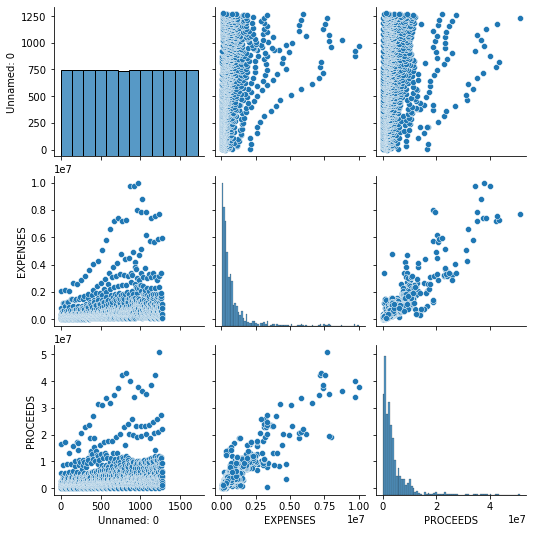

In [11]:
sns.pairplot(df)

In [12]:
df2 = df.copy()
df2 = df2.dropna(axis=0)

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 1274
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1275 non-null   int64  
 1   PRIMARY_KEY  1275 non-null   object 
 2   EXPENSES     1275 non-null   float64
 3   PROCEEDS     1275 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 49.8+ KB


In [14]:
df2["доход"] = df2['PROCEEDS'] - df2['EXPENSES']

In [15]:
df2.head()

,Unnamed: 0,PRIMARY_KEY,EXPENSES,PROCEEDS,доход
0,0,2017_Speech synthesis,304177.0,1659028.0,1354851.0
1,1,2017_Watson,106780.0,720711.0,613931.0
2,2,2017_OCR,297888.0,1369815.0,1071927.0
3,3,2017_Speech recognition,178571.0,958785.0,780214.0
4,4,2017_Transformer,2072470.0,16546514.0,14474044.0


In [20]:
tq = df2['PRIMARY_KEY'].tolist()
for i in range(len(tq)):
    tq[i] = tq[i][tq[i].find('_')+1:]
print(tq)

['Speech synthesis', 'Watson', 'OCR', 'Speech recognition', 'Transformer', 'Facial recognition', 'GPT-2', 'AlphaGo', 'Transformer', 'GPT-3', 'GPT-3', 'Human image synthesis', 'WaveNet', 'WaveNet', 'WaveNet', 'WaveNet', 'Self-driving car', 'Self-driving car', 'Self-driving car', 'Self-driving car', 'GPT-3', 'GPT-3', 'GPT-3', 'GPT-3', 'Transformer', 'Transformer', 'Transformer', 'Transformer', 'Transformer', 'OCR', 'OCR', 'OCR', 'OCR', 'OCR', 'OCR', 'Speech synthesis', 'Speech synthesis', 'Speech synthesis', 'Speech synthesis', 'Speech synthesis', 'BERT', 'BERT', 'BERT', 'GPT-2', 'Speech recognition', 'Speech recognition', 'Speech recognition', 'Word2vec', 'Speech recognition', 'Q-learning', 'MuZero', 'Speech synthesis', 'Watson', 'OCR', 'Speech recognition', 'Transformer', 'Facial recognition', 'GPT-2', 'AlphaGo', 'Transformer', 'GPT-3', 'GPT-3', 'Human image synthesis', 'WaveNet', 'WaveNet', 'WaveNet', 'WaveNet', 'Self-driving car', 'Self-driving car', 'Self-driving car', 'Self-driving

In [21]:
df2['технология'] = tq

In [22]:
df2.head()

,Unnamed: 0,PRIMARY_KEY,EXPENSES,PROCEEDS,доход,технология
0,0,2017_Speech synthesis,304177.0,1659028.0,1354851.0,Speech synthesis
1,1,2017_Watson,106780.0,720711.0,613931.0,Watson
2,2,2017_OCR,297888.0,1369815.0,1071927.0,OCR
3,3,2017_Speech recognition,178571.0,958785.0,780214.0,Speech recognition
4,4,2017_Transformer,2072470.0,16546514.0,14474044.0,Transformer


In [23]:
#df2["технология"] = df2.groupby("PRIMARY_KEY").agg({"доход" : np.mean}) 
#df2["технология"] = df2.groupby("PRIMARY_KEY").agg({"доход" : np.mean}) 

res = (df2.groupby(pd.Grouper(key='технология'))
                  ['доход']
                  .mean()
                  .reset_index(name='доход от технологии'))

In [24]:
res.head()

,технология,доход от технологии
0,Speech synthesis,3.227248e+06
1,Watson,8.180296e+05
2,OCR,4.543448e+06
3,Speech recognition,1.877511e+06
4,Transformer,4.522072e+06


In [25]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   технология           16 non-null     object 
 1   доход от технологии  16 non-null     float64
dtypes: float64(1), object(1)
memory usage: 384.0+ bytes


In [26]:
print(res.sort_values(by=['доход от технологии'], ascending=False))

               технология  доход от технологии
8                   GPT-3         5.854825e+06
6                   GPT-2         5.403160e+06
2                     OCR         4.543448e+06
4             Transformer         4.522072e+06
13               Word2vec         3.972267e+06
14             Q-learning         3.832498e+06
0        Speech synthesis         3.227248e+06
10                WaveNet         3.163811e+06
5      Facial recognition         3.082242e+06
3      Speech recognition         1.877511e+06
11       Self-driving car         1.790330e+06
12                   BERT         1.556297e+06
9   Human image synthesis         1.547022e+06
1                  Watson         8.180296e+05
7                 AlphaGo         7.303885e+05
15                 MuZero         5.248982e+05


In [30]:
df3 = df2[['технология','доход']] 
bs1 = df3[df3['технология'] == 'GPT-3' ]
print(len(bs1))

bs1_list = bs1['доход' ].tolist()
#print(bs1_list)

150


In [31]:
bs1.head()

,технология,доход
9,GPT-3,4895529.0
10,GPT-3,2399973.0
20,GPT-3,1550498.0
21,GPT-3,1165105.0
22,GPT-3,2001463.0


In [32]:

bs2 = df3[df3['технология'] == 'GPT-2' ]
print(len(bs2))
bs2_list = bs2['доход'].tolist()

50


In [33]:
bs2.head()

,технология,доход
6,GPT-2,-1003.0
43,GPT-2,-489490.0
57,GPT-2,-5665.0
94,GPT-2,-241485.0
108,GPT-2,11372.0


In [34]:
bs3 = df3[df3['технология'] == 'OCR' ]
print(len(bs3))
bs3_list = bs3['доход'].tolist()

175


In [36]:
bs3.head()

,технология,доход
2,OCR,1071927.0
29,OCR,55276.0
30,OCR,4088655.0
31,OCR,829133.0
32,OCR,7525633.0


In [37]:
B = 50000

N1 = 150
N2 = 50
N3 = 175

#k = random.randint(0,29)
#print(k)

In [42]:
def BTS(a, N):
    individual_estimates2 = np.empty(B)
    for i in range(B):
        individual_estimates0 = np.empty(N)
        for j in range(N):
            k = random.randint(0,N-1)
            choice = a[k]
            individual_estimates0[j] = choice
        individual_estimates1 = individual_estimates0.mean()
    
        individual_estimates2[i] = individual_estimates1
    
    bmean = individual_estimates2.mean()

    bstd = individual_estimates2.std()

    lower = bmean + norm.ppf(0.025)*bstd

    upper = bmean + norm.ppf(0.975)*bstd
    
    print(lower,' ',upper)
    
    

In [43]:
BTS(bs1_list, N1)

5362553.382433384   6351465.41517035


In [44]:
BTS(bs2_list, N2)

3875023.692199307   6929905.444387891


In [45]:
BTS(bs3_list, N3)

3742340.801428384   5347973.916346702
